# Portfolio Risk Analysis and Optimization using Monte Carlo Simulation

This project simulates random portfolios based on selected assets and identifies the optimal portfolio using key metrics like Sharpe Ratio and Volatility.

## Objectives:
- Simulate 10,000+ portfolios with random weights
- Calculate return, volatility, and Sharpe ratio
- Identify the optimal portfolio based on max Sharpe and min volatility
- Visualize the efficient frontier

Import all the relevant libraries. I use yfinance library to gain access to stock data via the yahoo finance api.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

For this portfolio I will include in the stock basket: Apple, Microsoft, Google, JP Morgan, Tesla and IBM stocks. This 
basket is diverse enough for my purposes and can allow me to make insights about risks based on volatility and returns.

In [2]:
symbols = ['AAPL', 'MSFT', 'GOOGL', 'JPM', 'TSLA', 'IBM']
num_of_symbols = len(symbols)
stock_data = 'stock_data.csv'

I use a 5 year period from 2020 up until the end of 2024. 

In [3]:
START_DATE = '2020-01-01'
END_DATE = '2024-12-31'

The raw data is imported through the yfinance library. I then extract the closing prices for the stocks adjusted for coorporate actions like stock splits and dividend distributions.

In [4]:
raw_data = yf.download(symbols, start=START_DATE, end=END_DATE, auto_adjust = False)
stock_prices = raw_data['Adj Close']
display(stock_prices)

[*********************100%***********************]  6 of 6 completed


Ticker,AAPL,GOOGL,IBM,JPM,MSFT,TSLA
Date,,,,,,
2020-01-02,72.620819,68.026024,101.245125,120.733543,153.042313,28.684000
2020-01-03,71.914833,67.670151,100.437683,119.140305,151.136673,29.534000
2020-01-06,72.487862,69.473846,100.258240,119.045563,151.527328,30.102667
2020-01-07,72.146942,69.339638,100.325523,117.021744,150.145721,31.270666
2020-01-08,73.307518,69.833183,101.162880,117.934624,152.537308,32.809334
...,...,...,...,...,...,...
2024-12-23,254.655716,194.171036,219.003876,235.713242,433.583038,430.600006
2024-12-24,257.578674,195.647552,221.451202,239.589218,437.647400,462.279999
2024-12-26,258.396667,195.138748,221.924866,240.409912,436.432068,454.130005


We load the raw data into the csv file

In [5]:
stock_prices.to_csv(stock_data)
stock_data

'stock_data.csv'

In [6]:
portfolio_data = pd.read_csv(stock_data, index_col = 'Date')
display(portfolio_data.head())

,AAPL,GOOGL,IBM,JPM,MSFT,TSLA
Date,,,,,,
2020-01-02,72.620819,68.026024,101.245125,120.733543,153.042313,28.684000
2020-01-03,71.914833,67.670151,100.437683,119.140305,151.136673,29.534000
2020-01-06,72.487862,69.473846,100.258240,119.045563,151.527328,30.102667
2020-01-07,72.146942,69.339638,100.325523,117.021744,150.145721,31.270666
2020-01-08,73.307518,69.833183,101.162880,117.934624,152.537308,32.809334


In [7]:
display(portfolio_data.tail())

,AAPL,GOOGL,IBM,JPM,MSFT,TSLA
Date,,,,,,
2024-12-23,254.655716,194.171036,219.003876,235.713242,433.583038,430.600006
2024-12-24,257.578674,195.647552,221.451202,239.589218,437.647400,462.279999
2024-12-26,258.396667,195.138748,221.924866,240.409912,436.432068,454.130005
2024-12-27,254.974930,192.305435,219.842682,238.462036,428.881104,431.660004
2024-12-30,251.593094,190.789047,217.346039,236.632812,423.202911,417.410004


I use a standard way to visualise the adjusted closing prices over time. An overall basic analysis can be done looking at these prices. We see how Tesla's stock price has been growing over time much faster than other stocks in the portfolio. I can see that there is much more variation in Microsoft's stock prices in this period.

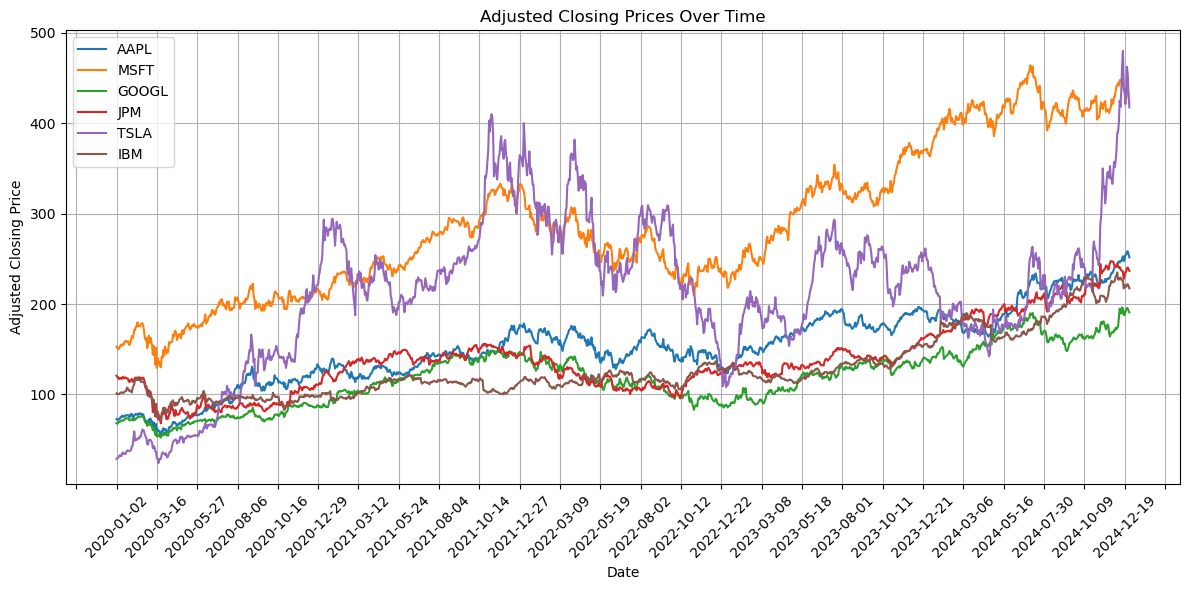

In [8]:
plt.figure(figsize=(12, 6))
for symbol in symbols:
    plt.plot(portfolio_data.index, portfolio_data[symbol], label=symbol)

plt.xlabel("Date")
plt.ylabel("Adjusted Closing Price")
plt.title("Adjusted Closing Prices Over Time")
plt.legend(loc="upper left")
plt.grid(True)

# x-axis are rotated labels for better readability
plt.xticks(rotation=45)

# Reduce the number of displayed date labels
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(30))  # Adjust the number as needed

plt.tight_layout()
plt.show()

### Portfolio Metrics 

Next, I find the general portfolio metrics of daily returns (percentage change in the stock 
closing prices per day; log returns (which are summable over time).

In [9]:
daily_returns = portfolio_data.pct_change().dropna()
daily_returns.head()

,AAPL,GOOGL,IBM,JPM,MSFT,TSLA
Date,,,,,,
2020-01-03,-0.009722,-0.005231,-0.007975,-0.013196,-0.012452,0.029633
2020-01-06,0.007968,0.026654,-0.001787,-0.000795,0.002585,0.019255
2020-01-07,-0.004703,-0.001932,0.000671,-0.017000,-0.009118,0.038801
2020-01-08,0.016086,0.007118,0.008346,0.007801,0.015928,0.049205
2020-01-09,0.021241,0.010498,0.010569,0.003651,0.012493,-0.021945


In [10]:
display(daily_returns.tail())

,AAPL,GOOGL,IBM,JPM,MSFT,TSLA
Date,,,,,,
2024-12-23,0.003065,0.016823,-0.006402,0.003325,-0.003092,0.022657
2024-12-24,0.011478,0.007604,0.011175,0.016444,0.009374,0.073572
2024-12-26,0.003176,-0.002601,0.002139,0.003425,-0.002777,-0.017630
2024-12-27,-0.013242,-0.014519,-0.009382,-0.008102,-0.017302,-0.049479
2024-12-30,-0.013263,-0.007885,-0.011356,-0.007671,-0.013240,-0.033012


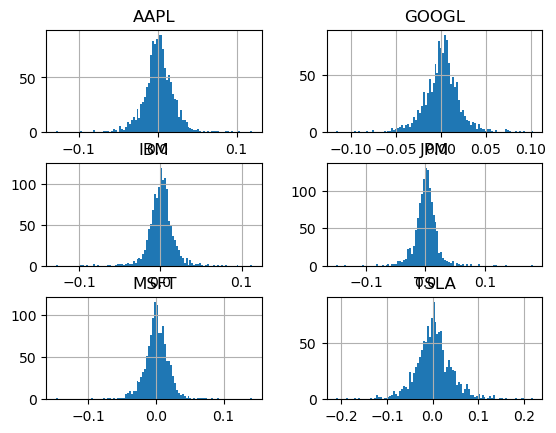

None

In [11]:
#we check the distribution of daily returns 
daily_returns.hist(bins=100)
display(plt.show())

In [12]:
#we find log returns to capture the idea of returns over time
log_returns  = np.log(1 +  portfolio_data.pct_change())
display(log_returns.head())

,AAPL,GOOGL,IBM,JPM,MSFT,TSLA
Date,,,,,,
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,-0.009769,-0.005245,-0.008007,-0.013284,-0.012530,0.029203
2020-01-06,0.007937,0.026305,-0.001788,-0.000796,0.002581,0.019072
2020-01-07,-0.004714,-0.001934,0.000671,-0.017147,-0.009160,0.038067
2020-01-08,0.015958,0.007093,0.008312,0.007771,0.015803,0.048033


We see that raw log returns are as follows, with Tesla having the highest at 0.53 points. Note that we adjust the
value to calculate said returns annually over 252 live days for the market.

In [13]:
log_returns.mean() * 252

AAPL     0.249304
GOOGL    0.206912
IBM      0.153276
JPM      0.135013
MSFT     0.204075
TSLA     0.537251
dtype: float64

A standard way to analyse how stocks in our portfolio vary together is through covariance and correlation matrices.
When Apple's stock prices go up do we have a genearl trend of Microsoft's going up ? If so this is how we measure it.

In [14]:
#the covariance matrix
log_returns.cov()*252

,AAPL,GOOGL,IBM,JPM,MSFT,TSLA
AAPL,0.100265,0.067248,0.033830,0.042592,0.072596,0.104471
GOOGL,0.067248,0.105840,0.031208,0.042929,0.074289,0.088513
IBM,0.033830,0.031208,0.071939,0.049763,0.033981,0.029200
JPM,0.042592,0.042929,0.049763,0.105375,0.042063,0.061411
MSFT,0.072596,0.074289,0.033981,0.042063,0.093226,0.093285
TSLA,0.104471,0.088513,0.029200,0.061411,0.093285,0.448998


In [15]:
log_returns.corr()

,AAPL,GOOGL,IBM,JPM,MSFT,TSLA
AAPL,1.000000,0.652798,0.398329,0.414365,0.750878,0.492377
GOOGL,0.652798,1.000000,0.357647,0.406499,0.747878,0.406032
IBM,0.398329,0.357647,1.000000,0.571556,0.414945,0.162470
JPM,0.414365,0.406499,0.571556,1.000000,0.424383,0.282330
MSFT,0.750878,0.747878,0.414945,0.424383,1.000000,0.455952
TSLA,0.492377,0.406032,0.162470,0.282330,0.455952,1.000000


### Monte Carlo Simulation

Monte Carlo Simulation involves performing multiple iterations (can be maximised to increase robustness of model) of assigning random
weights to each item in our portfolio and analysing the returns, volatility and Sharpe Ratio ( a metric to identify the risk adjusted returns we get ) for each of them. 

### What is the Sharpe Ratio?
The Sharpe Ratio measures risk-adjusted return:  
$$ S = \frac{R_p - R_f}{\sigma_p} $$
where Rp is the portfolio return, Rf is the risk-free rate, and denominator is portfolio volatility.

The following is one iteration of the same

In [16]:
#assigning random weights to each symbol in the portfolio to begin monte carlo simulation
random_weights = np.array(np.random.random(num_of_symbols))

#weights should be standaradsed
rebalanced_weights = random_weights / np.sum(random_weights)

display(rebalanced_weights)

array([0.06003073, 0.23690183, 0.23996591, 0.18398929, 0.06779152,
       0.21132072])

In [17]:
#calculate the expected returns, annualized according to number of trading days 252
expected_returns = np.sum(log_returns.mean() * rebalanced_weights) * 252
expected_returns

np.float64(0.25297274760402566)

In [18]:
expected_volatility = np.sqrt(
    np.dot(
        rebalanced_weights.T,
        np.dot(
            log_returns.cov()*252, 
            rebalanced_weights
        )
    )
)
expected_volatility

np.float64(0.27759219877780816)

Here I assume a risk free rate on returns to be 0.015 points, say we invest in government treasury bonds. The 
general assumption is that the government doesnt defualt on their returns.

In [19]:
#Sharpe Ratio
#assume some risk free rate of returns say returns on government treasury bonds
risk_free_returns = 0.015 

sharpe_ratio = (expected_returns - risk_free_returns)/expected_volatility

We create a data frame to store all our metrics

In [20]:
#create a data frame with our portfolio metrics for one itereation or one simulation
#we run multiple such iterations - the monte carlo simulation
metrics_df = pd.DataFrame(data = {
    'Expected Portfolio Returns': expected_returns,
    'Expected Portfolio Volatility': expected_volatility,
    'Portfolio Sharpe Ratio': sharpe_ratio
    }, index = [0])

metrics_df.head()

,Expected Portfolio Returns,Expected Portfolio Volatility,Portfolio Sharpe Ratio
0,0.252973,0.277592,0.857275


Here is the main Monte Carlo Simulation code. we are essentially working with an array of different generated 
portfolios with randomly assigned weights and figuring out the metrics for each of them.

In [21]:
num_of_portfolios = 10500

In [22]:
#we look for the minimum expected volatility and highest sharpe ratio (basically most return 
#for that amount of risk. number of simulations is the number of portfolios we get

#predefine/ initialize arrays for storage of the values for each portfolio
weights_arr = np.zeros((num_of_portfolios, num_of_symbols))

returns_arr = np.zeros(num_of_portfolios)

volatility_arr = np.zeros(num_of_portfolios)

sharpe_arr = np.zeros(num_of_portfolios)

for i in range(num_of_portfolios):
    #calculate the weights:
    weights = np.array(np.random.random(num_of_symbols))
    #standardize the weights
    weights = weights / np.sum(weights)

    weights_arr[i, :] = weights

    returns_arr[i] = np.sum((log_returns.mean() * weights))*252

    volatility_arr[i] = np.sqrt(
        np.dot(
            weights.T,
            np.dot(
                log_returns.cov()*252, 
                weights
            )
        )
    )

    sharpe_arr[i] = (returns_arr[i] - risk_free_returns)/ volatility_arr[i]

In [23]:
simulated_data = [returns_arr, volatility_arr, sharpe_arr, weights_arr]

simulated_df = pd.DataFrame(data = simulated_data).T

simulated_df.columns = ['Returns', 'Volatility', 'Sharpe Ratio', 'Portfolio Weights']

display(simulated_df)

,Returns,Volatility,Sharpe Ratio,Portfolio Weights
0,0.23165,0.274662,0.788787,"[0.30864094936740505, 0.32464428101831194, 0.0..."
1,0.242967,0.283516,0.804072,"[0.08978629251538238, 0.09366988225389386, 0.0..."
2,0.25316,0.280028,0.850485,"[0.14796621852198094, 0.19874743060382513, 0.1..."
3,0.209996,0.250188,0.779398,"[0.19467633930315678, 0.20115512887253892, 0.1..."
4,0.300136,0.32788,0.869637,"[0.24098189031163864, 0.02068927353885732, 0.0..."
...,...,...,...,...
10495,0.240228,0.26878,0.837966,"[0.03667241496476079, 0.05028296128560054, 0.3..."
10496,0.186975,0.242176,0.710126,"[0.14395434552279374, 0.26785572204935776, 0.1..."
10497,0.215587,0.262142,0.765183,"[0.3354244583512521, 0.07414536912486343, 0.06..."
10498,0.266841,0.288808,0.871999,"[0.2406274842026472, 0.1879331748538503, 0.116..."


### Optimization 

Can be done in two simplel ways here: identify the portfolio with which we get the most returns for a set amount of risk
(risk adjusted returns) using the Sharpe Ratio metric. Or we extract the portfolio with the least volatility, hence the least amount of
risk involved.

In [24]:
#portfolio with the highest sharpe ratio

max_sharpe_port = simulated_df.loc[simulated_df['Sharpe Ratio'].idxmax()]

min_vol_port = simulated_df.loc[simulated_df['Volatility'].idxmin()]

print("Max Sharpe Ratio Portfolio")
print(max_sharpe_port)

print('-'*100)
print("Min Volatility Portfolio")
print(min_vol_port)


Max Sharpe Ratio Portfolio
Returns                                                       0.287227
Volatility                                                    0.296951
Sharpe Ratio                                                   0.91674
Portfolio Weights    [0.25169155068382776, 0.06707783608641239, 0.3...
Name: 9950, dtype: object
----------------------------------------------------------------------------------------------------
Min Volatility Portfolio
Returns                                                       0.185449
Volatility                                                    0.232712
Sharpe Ratio                                                  0.732444
Portfolio Weights    [0.22901920330441544, 0.15599913599625995, 0.5...
Name: 3682, dtype: object


### Conclusion

The weights for these optimized portfolios I generated are as follows. For most risk-adjusted returns invest most in Apple, 
IBM and Tesla.

The Most Optimal Sharpe Ratio is 92% on Expected Returns of about 30%

In [25]:
display(max_sharpe_port['Portfolio Weights'])

array([0.25169155, 0.06707784, 0.3950445 , 0.00143106, 0.0093923 ,
       0.27536275])

For least risk portfolios invest most in IBM. We see that investing in Tesla has quite a lot of
volatility and risk involved.

The expected returns on this portfolio with minimum volatility is about 18.5%

In [26]:
display(min_vol_port['Portfolio Weights'])

array([0.2290192 , 0.15599914, 0.50801223, 0.06933155, 0.03413338,
       0.0035045 ])